In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from warnings import filterwarnings
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [2]:
types = pd.read_csv('types.csv', sep = ';')
codes = pd.read_csv('codes.csv', sep = ';')
transactions = pd.read_csv('transactions.csv', sep = ';')
train_set = pd.read_csv('train_set.csv', sep = ';')

## Descriptive Analysis

In [3]:
types.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
type,155.0,NaN,NaN,NaN,10819.045161,80000.258847,1000.0,2385.5,4040.0,7027.5,999999.0
type_description,155,139,н/д,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
codes.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
code,184.0,NaN,NaN,NaN,6046.793478,1470.328104,742.0,5208.25,5813.5,7283.0,9402.0
code_description,184,184,"Магазины по продаже часов, ювелирных изделий и...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
transactions.describe(include = 'all').T
# mean value of sum(-18129.1) is less than median value(-5502.49)
# also we have very big difference between max value and 75%tile, it means that most of our values are negative

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,130039.0,NaN,NaN,NaN,50868594.197495,28728539.409404,22899.0,25771743.0,52358368.0,75063019.0,99999680.0
datetime,130039,114770,456 00:00:00,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code,130039.0,NaN,NaN,NaN,5594.629996,606.087084,742.0,5211.0,5641.0,6010.0,9402.0
type,130039.0,NaN,NaN,NaN,2489.372135,2253.296578,1000.0,1030.0,1110.0,2370.0,8145.0
sum,130039.0,NaN,NaN,NaN,-18129.093893,558444.522435,-41500301.14,-22449.16,-5502.49,-1122.96,67377473.16


In [6]:
#merge transactions, types, codes and train_set
df = pd.merge(pd.merge(pd.merge(transactions, types), codes), train_set)
df.head()

,client_id,datetime,code,type,sum,type_description,code_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0
1,96372458,68 02:04:11,6011,2010,-426724.00,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0
2,96372458,433 06:45:32,6011,2010,-112295.79,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0
3,96372458,270 06:16:18,6011,7010,224591.58,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,0
4,96372458,4 09:33:46,4814,1030,-2245.92,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0


In [7]:
df.mode()

,client_id,datetime,code,type,sum,type_description,code_description,target
0,70780820,456 00:00:00,6011,1010,-2245.92,Покупка. POS,Финансовые институты — снятие наличности автом...,0


In [8]:
print('Range:', max(transactions['sum']) - min(transactions['sum'])) # Measures of spread
print('IQR:', transactions['sum'].quantile(0.75) - transactions['sum'].quantile(0.25))
print('Variance:', transactions['sum'].var())
print('Standart deviation:',  transactions['sum'].std())

Range: 108877774.3
IQR: 21326.2
Variance: 311860284637.5772
Standart deviation: 558444.5224349302


## Explanatory Data Analysis

In [9]:
df.shape
# Dataset comprises of 129998 observations and 7 characteristics

(91800, 8)

In [10]:
df.columns

Index(['client_id', 'datetime', 'code', 'type', 'sum', 'type_description',
       'code_description', 'target'],
      dtype='object')

In [11]:
df.nunique() # number of unique values for every column

client_id            6000
datetime            81491
code                  173
type                   58
sum                 20856
type_description       53
code_description      173
target                  2
dtype: int64

In [12]:
df.info()
# our data have integer, float and object values, object values used for datetime and text in type, code descriptions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91800 entries, 0 to 91799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         91800 non-null  int64  
 1   datetime          91800 non-null  object 
 2   code              91800 non-null  int64  
 3   type              91800 non-null  int64  
 4   sum               91800 non-null  float64
 5   type_description  91800 non-null  object 
 6   code_description  91800 non-null  object 
 7   target            91800 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 6.3+ MB


In [13]:
df.isna().any()
# as we can see we have no null/missing values, so we dont need to delete them

client_id           False
datetime            False
code                False
type                False
sum                 False
type_description    False
code_description    False
target              False
dtype: bool

In [14]:
clients = np.array(df['client_id'].unique())
len(clients) # number of unique clients

6000

In [15]:
df.drop_duplicates(inplace = True)
df.shape 
# shape of dataframe before deleting dublicates = (129998, 7)
# 129998-129969 = 29 rows was deleted

(91781, 8)

## Visualizations

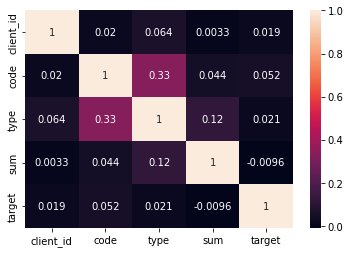

In [16]:
# Realtionship analysis based on correlation matrix
correlation = df.corr()
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, annot = True)
plt.show()
# the higher correlation coefficient between type and code 
# type of transaction has the greatest influence on sum

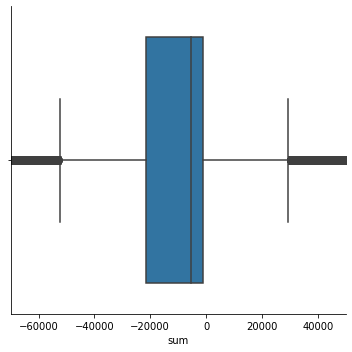

In [17]:
# box plot
sns.catplot(x = 'sum', kind = 'box', data = df)
plt.xlim(-70000, 50000)
plt.show()

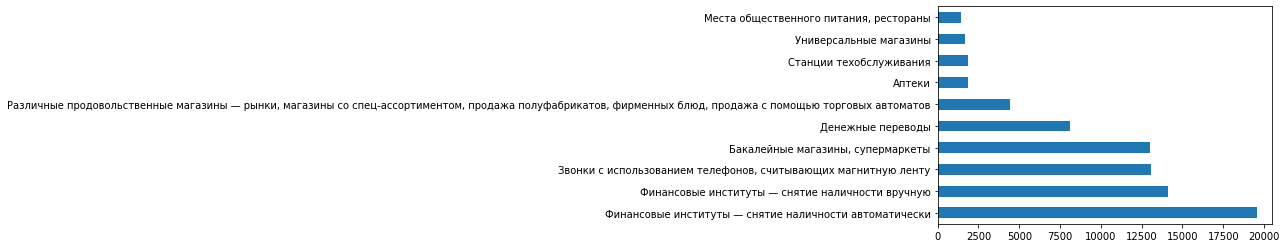

In [18]:
# graphs show Top 10 codes of transactions
df['code_description'].value_counts()[0:10].plot.barh()
plt.show()

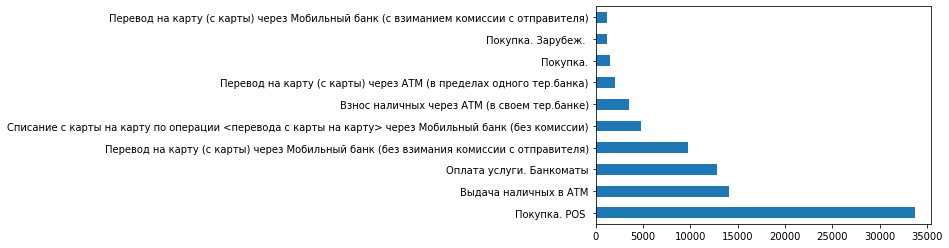

In [19]:
# graphs show Top 10 types of transactions
df['type_description'].value_counts()[0:10].plot.barh()
plt.show()

## Feature engineering and Data cleaning

In [20]:
# divide datetime column to date and time columns
df[['day', 'time']] = df['datetime'].str.split(' ', expand = True)
df[['hour', 'minute','second']] = df['time'].str.split(':', expand=True)

In [21]:
df.head()

,client_id,datetime,code,type,sum,type_description,code_description,target,day,time,hour,minute,second
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,421,06:33:15,06,33,15
1,96372458,68 02:04:11,6011,2010,-426724.00,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,68,02:04:11,02,04,11
2,96372458,433 06:45:32,6011,2010,-112295.79,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,433,06:45:32,06,45,32
3,96372458,270 06:16:18,6011,7010,224591.58,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,0,270,06:16:18,06,16,18
4,96372458,4 09:33:46,4814,1030,-2245.92,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0,4,09:33:46,09,33,46


In [22]:
df = df.astype({'day': int})
df = df.astype({'hour': int})
df = df.astype({'minute': int})
df = df.astype({'second': int})

In [23]:
date = datetime.datetime(2021, 1, 1) # start date is 1 january of 2021
step = datetime.timedelta(days = 1)
dates = {} # dictionary will store the serial number of the date and date
date_list = []
for i in range(0, 457):
    dates[i] = date.strftime('%Y-%m-%d')
    date += step
    
for i in df['day']:
    date_list.append(dates[i])
#new column date
df['date'] = date_list
df

,client_id,datetime,code,type,sum,type_description,code_description,target,day,time,hour,minute,second,date
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,421,06:33:15,6,33,15,2022-02-26
1,96372458,68 02:04:11,6011,2010,-426724.00,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,68,02:04:11,2,4,11,2021-03-10
2,96372458,433 06:45:32,6011,2010,-112295.79,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,433,06:45:32,6,45,32,2022-03-10
3,96372458,270 06:16:18,6011,7010,224591.58,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,0,270,06:16:18,6,16,18,2021-09-28
4,96372458,4 09:33:46,4814,1030,-2245.92,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0,4,09:33:46,9,33,46,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91795,77171868,194 08:39:03,4829,2340,-112295.79,Списание с карты по операции “перевода с карты...,Денежные переводы,0,194,08:39:03,8,39,3,2021-07-14
91796,79803584,151 13:46:48,4829,2340,-56147.89,Списание с карты по операции “перевода с карты...,Денежные переводы,1,151,13:46:48,13,46,48,2021-06-01
91797,66391854,425 15:33:02,4829,2331,-228364.72,Списание с карты по операции “перевода с карты...,Денежные переводы,1,425,15:33:02,15,33,2,2022-03-02
91798,15166647,432 00:00:00,5964,1200,-10284.50,Покупка. Зарубеж.,Прямой маркетинг — торговля через каталог,0,432,00:00:00,0,0,0,2022-03-09


In [24]:
df['date']

0        2022-02-26
1        2021-03-10
2        2022-03-10
3        2021-09-28
4        2021-01-05
            ...    
91795    2021-07-14
91796    2021-06-01
91797    2022-03-02
91798    2022-03-09
91799    2022-02-08
Name: date, Length: 91781, dtype: object

In [25]:
df[['year', 'month', 'day']] = df['date'].str.split('-', expand = True)
df

,client_id,datetime,code,type,sum,type_description,code_description,target,day,time,hour,minute,second,date,year,month
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,26,06:33:15,6,33,15,2022-02-26,2022,02
1,96372458,68 02:04:11,6011,2010,-426724.00,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,10,02:04:11,2,4,11,2021-03-10,2021,03
2,96372458,433 06:45:32,6011,2010,-112295.79,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,10,06:45:32,6,45,32,2022-03-10,2022,03
3,96372458,270 06:16:18,6011,7010,224591.58,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,0,28,06:16:18,6,16,18,2021-09-28,2021,09
4,96372458,4 09:33:46,4814,1030,-2245.92,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0,05,09:33:46,9,33,46,2021-01-05,2021,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91795,77171868,194 08:39:03,4829,2340,-112295.79,Списание с карты по операции “перевода с карты...,Денежные переводы,0,14,08:39:03,8,39,3,2021-07-14,2021,07
91796,79803584,151 13:46:48,4829,2340,-56147.89,Списание с карты по операции “перевода с карты...,Денежные переводы,1,01,13:46:48,13,46,48,2021-06-01,2021,06
91797,66391854,425 15:33:02,4829,2331,-228364.72,Списание с карты по операции “перевода с карты...,Денежные переводы,1,02,15:33:02,15,33,2,2022-03-02,2022,03
91798,15166647,432 00:00:00,5964,1200,-10284.50,Покупка. Зарубеж.,Прямой маркетинг — торговля через каталог,0,09,00:00:00,0,0,0,2022-03-09,2022,03


In [26]:
# change types of columns to int
df = df.astype({'year': int})
df = df.astype({'month': int})
df = df.astype({'day': int})

In [27]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 23):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [28]:
# new column sessions
df['sessions'] = df['hour'].apply(f)
df

,client_id,datetime,code,type,sum,type_description,code_description,target,day,time,hour,minute,second,date,year,month,sessions
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,26,06:33:15,6,33,15,2022-02-26,2022,2,Early Morning
1,96372458,68 02:04:11,6011,2010,-426724.00,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,10,02:04:11,2,4,11,2021-03-10,2021,3,Late Night
2,96372458,433 06:45:32,6011,2010,-112295.79,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0,10,06:45:32,6,45,32,2022-03-10,2022,3,Early Morning
3,96372458,270 06:16:18,6011,7010,224591.58,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,0,28,06:16:18,6,16,18,2021-09-28,2021,9,Early Morning
4,96372458,4 09:33:46,4814,1030,-2245.92,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0,5,09:33:46,9,33,46,2021-01-05,2021,1,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91795,77171868,194 08:39:03,4829,2340,-112295.79,Списание с карты по операции “перевода с карты...,Денежные переводы,0,14,08:39:03,8,39,3,2021-07-14,2021,7,Early Morning
91796,79803584,151 13:46:48,4829,2340,-56147.89,Списание с карты по операции “перевода с карты...,Денежные переводы,1,1,13:46:48,13,46,48,2021-06-01,2021,6,Noon
91797,66391854,425 15:33:02,4829,2331,-228364.72,Списание с карты по операции “перевода с карты...,Денежные переводы,1,2,15:33:02,15,33,2,2022-03-02,2022,3,Noon
91798,15166647,432 00:00:00,5964,1200,-10284.50,Покупка. Зарубеж.,Прямой маркетинг — торговля через каталог,0,9,00:00:00,0,0,0,2022-03-09,2022,3,Late Night


In [29]:
#convert to the positive values
df['sum'] = df['sum'].abs()
df.drop(['datetime', 'type_description', 'code_description', 'hour', 'minute','second','time', 'date', 'month', 'year', 'day'], axis = 1, inplace = True)
# copy dataframe
df1 = df.copy()
df.head()

,client_id,code,type,sum,target,sessions
0,96372458,6011,2010,561478.94,0,Early Morning
1,96372458,6011,2010,426724.00,0,Late Night
2,96372458,6011,2010,112295.79,0,Early Morning
3,96372458,6011,7010,224591.58,0,Early Morning
4,96372458,4814,1030,2245.92,0,Morning


In [30]:
df = pd.get_dummies(data = df, drop_first = True)

In [31]:
df.shape

(91781, 10)

In [32]:
df.head()

,client_id,code,type,sum,target,sessions_Eve,sessions_Late Night,sessions_Morning,sessions_Night,sessions_Noon
0,96372458,6011,2010,561478.94,0,0,0,0,0,0
1,96372458,6011,2010,426724.00,0,0,1,0,0,0
2,96372458,6011,2010,112295.79,0,0,0,0,0,0
3,96372458,6011,7010,224591.58,0,0,0,0,0,0
4,96372458,4814,1030,2245.92,0,0,0,1,0,0


In [33]:
scaler = MinMaxScaler()
df[['sum']] = scaler.fit_transform(df[['sum']])

In [34]:
df

,client_id,code,type,sum,target,sessions_Eve,sessions_Late Night,sessions_Morning,sessions_Night,sessions_Noon
0,96372458,6011,2010,0.008333,0,0,0,0,0,0
1,96372458,6011,2010,0.006333,0,0,1,0,0,0
2,96372458,6011,2010,0.001667,0,0,0,0,0,0
3,96372458,6011,7010,0.003333,0,0,0,0,0,0
4,96372458,4814,1030,0.000033,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
91795,77171868,4829,2340,0.001667,0,0,0,0,0,0
91796,79803584,4829,2340,0.000833,1,0,0,0,0,1
91797,66391854,4829,2331,0.003389,1,0,0,0,0,1
91798,15166647,5964,1200,0.000153,0,0,1,0,0,0


In [35]:
df_sales = df.loc[df.type.isin([1000, 1100, 1110, 1010, 1210, 1200])]
df_sales # dataframe consist only sales type of transactions
# тут мы вывели наши оснавные переменные для анализа а конкретнее code, type 
# и дополнительная переменная это время суток в котором происходит транзакция
# переделанная в вид подходящий рандомфорест и тд при помощи функций get_dummies

,client_id,code,type,sum,target,sessions_Eve,sessions_Late Night,sessions_Morning,sessions_Night,sessions_Noon
23,21717441,4814,1100,0.000080,0,0,0,1,0,0
24,21717441,5411,1010,0.001068,0,0,0,0,0,1
25,21717441,5732,1110,0.006157,0,0,0,1,0,0
27,21717441,7993,1200,0.000120,0,0,1,0,0,0
30,2444292,5411,1010,0.000046,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
91710,58819313,7995,1200,0.000057,0,0,1,0,0,0
91763,73117692,7311,1100,0.000033,0,0,1,0,0,0
91768,8890644,7995,1200,0.000052,1,0,1,0,0,0
91798,15166647,5964,1200,0.000153,0,0,1,0,0,0


In [36]:
len(df_sales['client_id'].unique())

4741

## Supervised learning. kNN,  Decision Trees,Random Forest.

In [37]:
X = df.drop(['client_id', 'target'], axis = 1)
y = df['target']
X1 = df_sales.drop(['client_id', 'target'], axis = 1)
y1 = df_sales['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2022)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 2022)
# разделяем наши данные на train и test часть с перемешиваем их в рандомном порядке(2022)

In [38]:
X

,code,type,sum,sessions_Eve,sessions_Late Night,sessions_Morning,sessions_Night,sessions_Noon
0,6011,2010,0.008333,0,0,0,0,0
1,6011,2010,0.006333,0,1,0,0,0
2,6011,2010,0.001667,0,0,0,0,0
3,6011,7010,0.003333,0,0,0,0,0
4,4814,1030,0.000033,0,0,1,0,0
...,...,...,...,...,...,...,...,...
91795,4829,2340,0.001667,0,0,0,0,0
91796,4829,2340,0.000833,0,0,0,0,1
91797,4829,2331,0.003389,0,0,0,0,1
91798,5964,1200,0.000153,0,1,0,0,0


### KNN

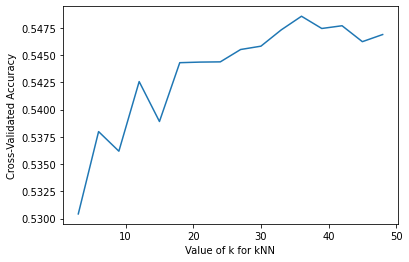

In [39]:
# KNN - это алгоритм обучения который используют в класстеризаций(или регрессии)
#  который для определения классификации точки объединяет классификацию K ближайших точек.
# Он является контролируемым, поскольку вы пытаетесь классифицировать точку на основе известной классификации других точек.
# отличается от k-means тем что KNN учитывает классификации других точек а k-means нет

filterwarnings(action = 'ignore', category = DeprecationWarning, message = '`np.bool` is a deprecated alias')

num_folds = 5

neighbors = range(3, 51, 3)

k_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X, y, cv = num_folds, scoring = 'accuracy')
    k_scores.append(scores.mean())
    
plt.plot(neighbors, k_scores)
plt.xlabel('Value of k for kNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
# здесь мы используем cross validation accuracy для нахождения лучшего k(количество ближайших точек в KNN) 

As we can see the best K is approximately 36. 

In [40]:
# здесь мы тоже находим лучший k но уже другим методом(для сравнения результатов)
# GridSearchCV это функция для удобного подбора гиперпараметров в алгоритмах машинного обучения
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 51)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv = 5)
#fit model to data
knn_gscv.fit(X, y)

knn_gscv.best_params_

{'n_neighbors': 36}

результат вышел один и тот же в двух случаях что говорит о правильности результатов 

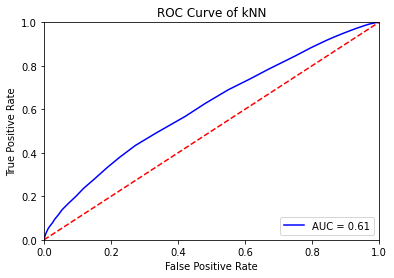

In [41]:
# здесь мы строим ROC curve of KNN для того чтобы оценить степень шума в наших данных
# из ROC cuve видно что AUC = 0.61 что говорит либо низкой либо о высокой степени шума в наших данных
from warnings import filterwarnings
filterwarnings(action = 'ignore', category = DeprecationWarning, message = '`np.int` is a deprecated alias')

knn = KNeighborsClassifier(n_neighbors = 50)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [42]:
print(classification_report(y_test, y_pred, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.58      0.67      0.62      9415
           1       0.58      0.49      0.53      8942

    accuracy                           0.58     18357
   macro avg       0.58      0.58      0.58     18357
weighted avg       0.58      0.58      0.58     18357



In [43]:
conf_matrix = confusion_matrix(y_test, y_pred).T #.transpose()
conf_matrix

array([[6268, 4553],
       [3147, 4389]], dtype=int64)

#### For the sales dataframe

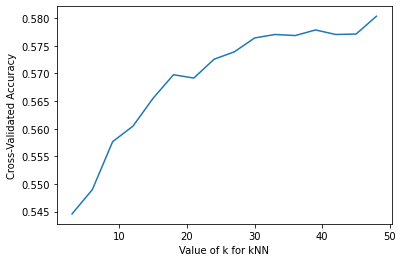

In [44]:
# cross-validation

from warnings import filterwarnings
filterwarnings(action = 'ignore', category = DeprecationWarning, message = '`np.bool` is a deprecated alias')

num_folds = 5

neighbors = range(3,51,3)

k_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X1, y1, cv = num_folds, scoring = 'accuracy')
    k_scores.append(scores.mean())
    
plt.plot(neighbors, k_scores)
plt.xlabel('Value of k for kNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

As we can see the best K is approximately between 47 and 51. 

In [45]:
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(48, 51)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X1, y1)

knn_gscv.best_params_

{'n_neighbors': 48}

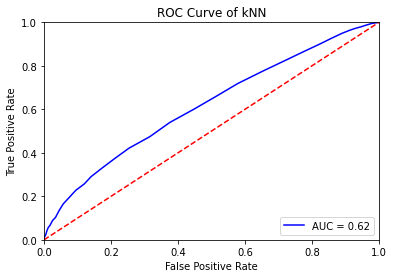

In [46]:
filterwarnings(action='ignore', category = DeprecationWarning, message = '`np.int` is a deprecated alias')

knn = KNeighborsClassifier(n_neighbors = 48)
knn.fit(X1_train, y1_train)

y_pred = knn.predict(X1_test)
y_scores = knn.predict_proba(X1_test)
fpr, tpr, threshold = roc_curve(y1_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [47]:
print(classification_report(y1_test, y_pred, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.58      0.62      0.60      3694
           1       0.59      0.54      0.56      3640

    accuracy                           0.58      7334
   macro avg       0.58      0.58      0.58      7334
weighted avg       0.58      0.58      0.58      7334



In [48]:
conf_matrix = confusion_matrix(y1_test, y_pred).T #.transpose()
conf_matrix

array([[2307, 1676],
       [1387, 1964]], dtype=int64)

### Decision Trees

In [49]:
#grid search

parameters = {'max_depth': range(3, 20)}
dt = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs = 4)
dt.fit(X = X, y = y)
dt_model = dt.best_estimator_
print (dt.best_score_, dt.best_params_)

0.5493076292618377 {'max_depth': 12}


As we can see the best max_depth is 12.

In [50]:
dt = DecisionTreeClassifier(max_depth = 12)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12)

In [51]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [52]:
predictions = dt.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [53]:
y_scores = dt.predict_proba(X_test)
y_scores

array([[0.54377147, 0.45622853],
       [0.47460686, 0.52539314],
       [0.54377147, 0.45622853],
       ...,
       [0.55178571, 0.44821429],
       [0.47623486, 0.52376514],
       [0.5140809 , 0.4859191 ]])

In [54]:
accuracy_score(y_test, predictions)

0.5746036934139566

In [55]:
conf_matrix = confusion_matrix(y_test, predictions, labels = [0, 1]).T #.transpose()
conf_matrix

array([[6307, 4701],
       [3108, 4241]], dtype=int64)

In [56]:
precision_score(y_test, predictions)

0.5770853177303035

In [57]:
recall_score(y_test, predictions)

0.4742786848579736

In [58]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62      9415
           1       0.58      0.47      0.52      8942

    accuracy                           0.57     18357
   macro avg       0.58      0.57      0.57     18357
weighted avg       0.57      0.57      0.57     18357



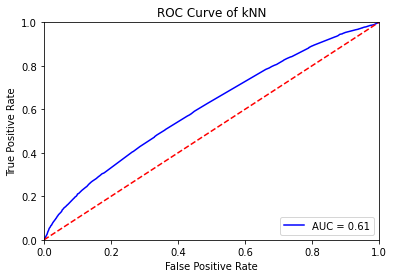

In [59]:
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [60]:
feature_names = X.columns
feature_names

Index(['code', 'type', 'sum', 'sessions_Eve', 'sessions_Late Night',
       'sessions_Morning', 'sessions_Night', 'sessions_Noon'],
      dtype='object')

In [61]:
dt.feature_importances_

array([0.26214092, 0.15780432, 0.44017625, 0.05993283, 0.03788173,
       0.00942628, 0.01413568, 0.01850199])

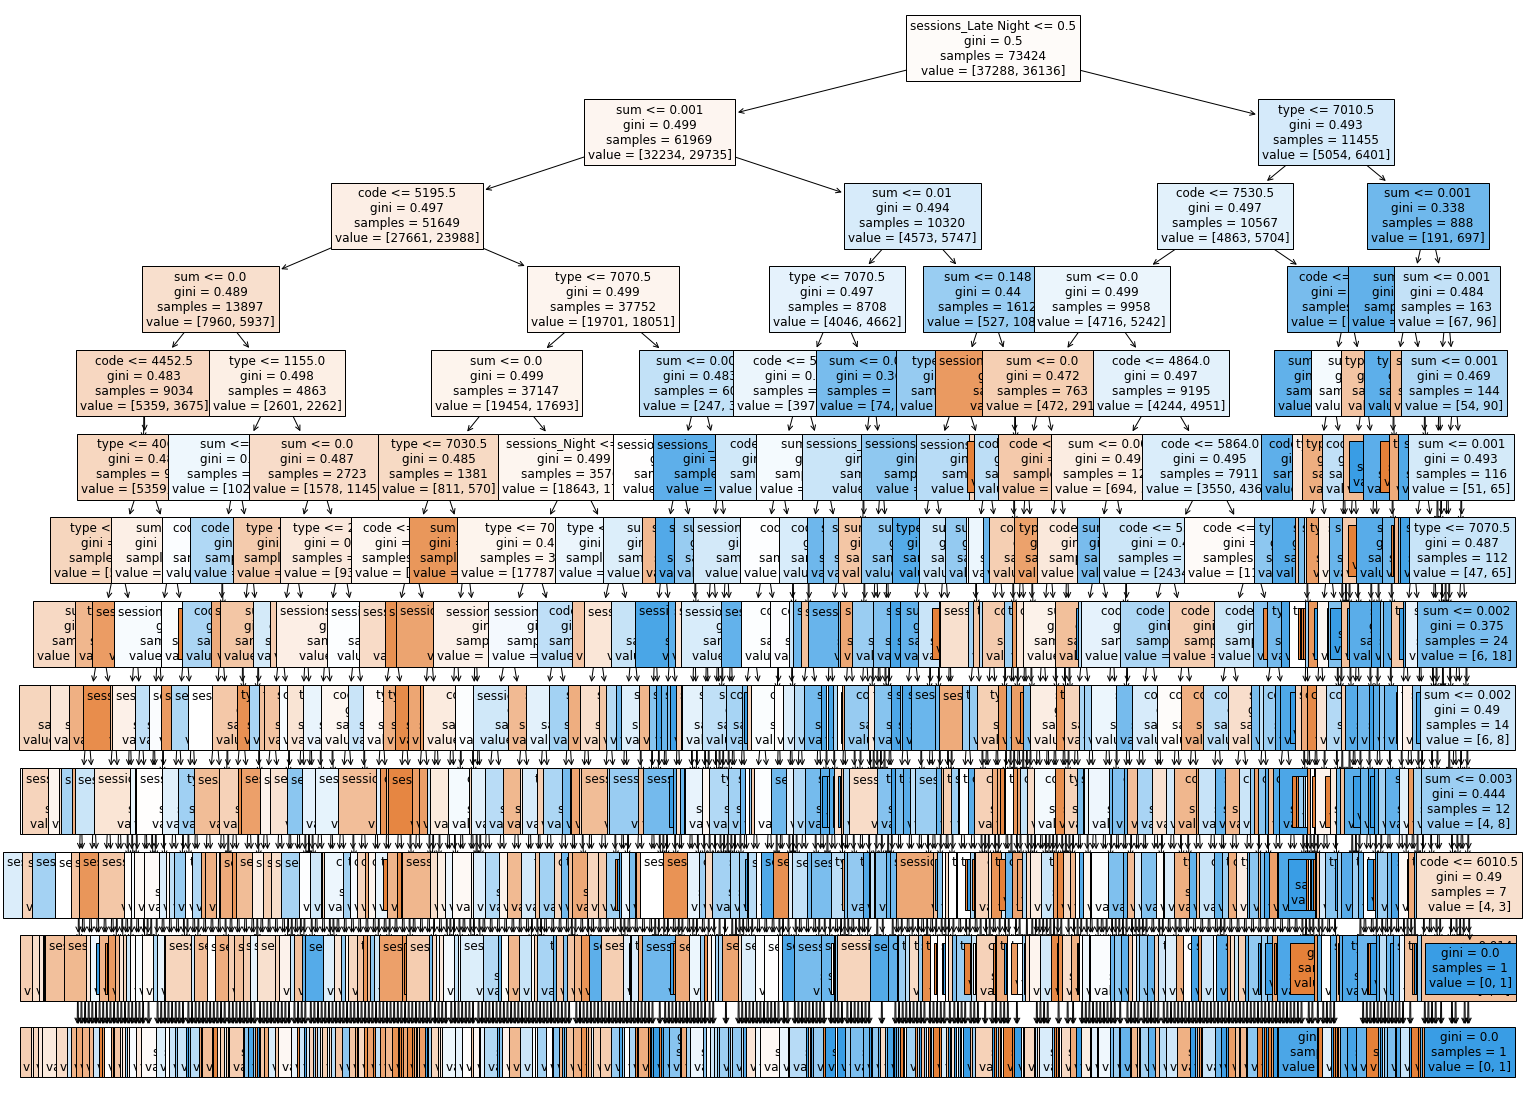

In [62]:
fig = plt.figure(figsize = (25, 20))
_= tree.plot_tree(dt,
                 feature_names = feature_names,
                 filled = True,
                 fontsize = 12)

#### For the sales dataframe

In [63]:
parameters = {'max_depth': range(3, 20)}
dt = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs = 4)
dt.fit(X = X1, y = y1)
dt_model = dt.best_estimator_
print (dt.best_score_, dt.best_params_)

0.5802335326916277 {'max_depth': 10}


In [64]:
dt = DecisionTreeClassifier(max_depth = 10)
dt.fit(X1_train, y1_train)
predictions = dt.predict(X1_test)
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [65]:
y1_scores = dt.predict_proba(X1_test)
y1_scores

array([[0.52      , 0.48      ],
       [0.46666667, 0.53333333],
       [0.45415473, 0.54584527],
       ...,
       [0.28089888, 0.71910112],
       [0.71428571, 0.28571429],
       [0.49923547, 0.50076453]])

In [66]:
print('Accuracy:', accuracy_score(y1_test, predictions), '\n')
print('Precision:', precision_score(y1_test, predictions), '\n')
print('Recall:', recall_score(y1_test, predictions), '\n')
print(classification_report(y1_test, predictions))

Accuracy: 0.5743114262339787 

Precision: 0.5755983654407473 

Recall: 0.5417582417582417 

              precision    recall  f1-score   support

           0       0.57      0.61      0.59      3694
           1       0.58      0.54      0.56      3640

    accuracy                           0.57      7334
   macro avg       0.57      0.57      0.57      7334
weighted avg       0.57      0.57      0.57      7334



In [67]:
confusion_matrix(y1_test, predictions, labels = [0, 1]).T

array([[2240, 1668],
       [1454, 1972]], dtype=int64)

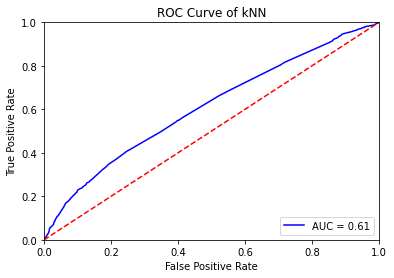

In [68]:
fpr, tpr, threshold = roc_curve(y1_test, y1_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [69]:
dt.feature_importances_

array([0.55464821, 0.03565256, 0.33403897, 0.01510125, 0.03483475,
       0.00274476, 0.01652425, 0.00645526])

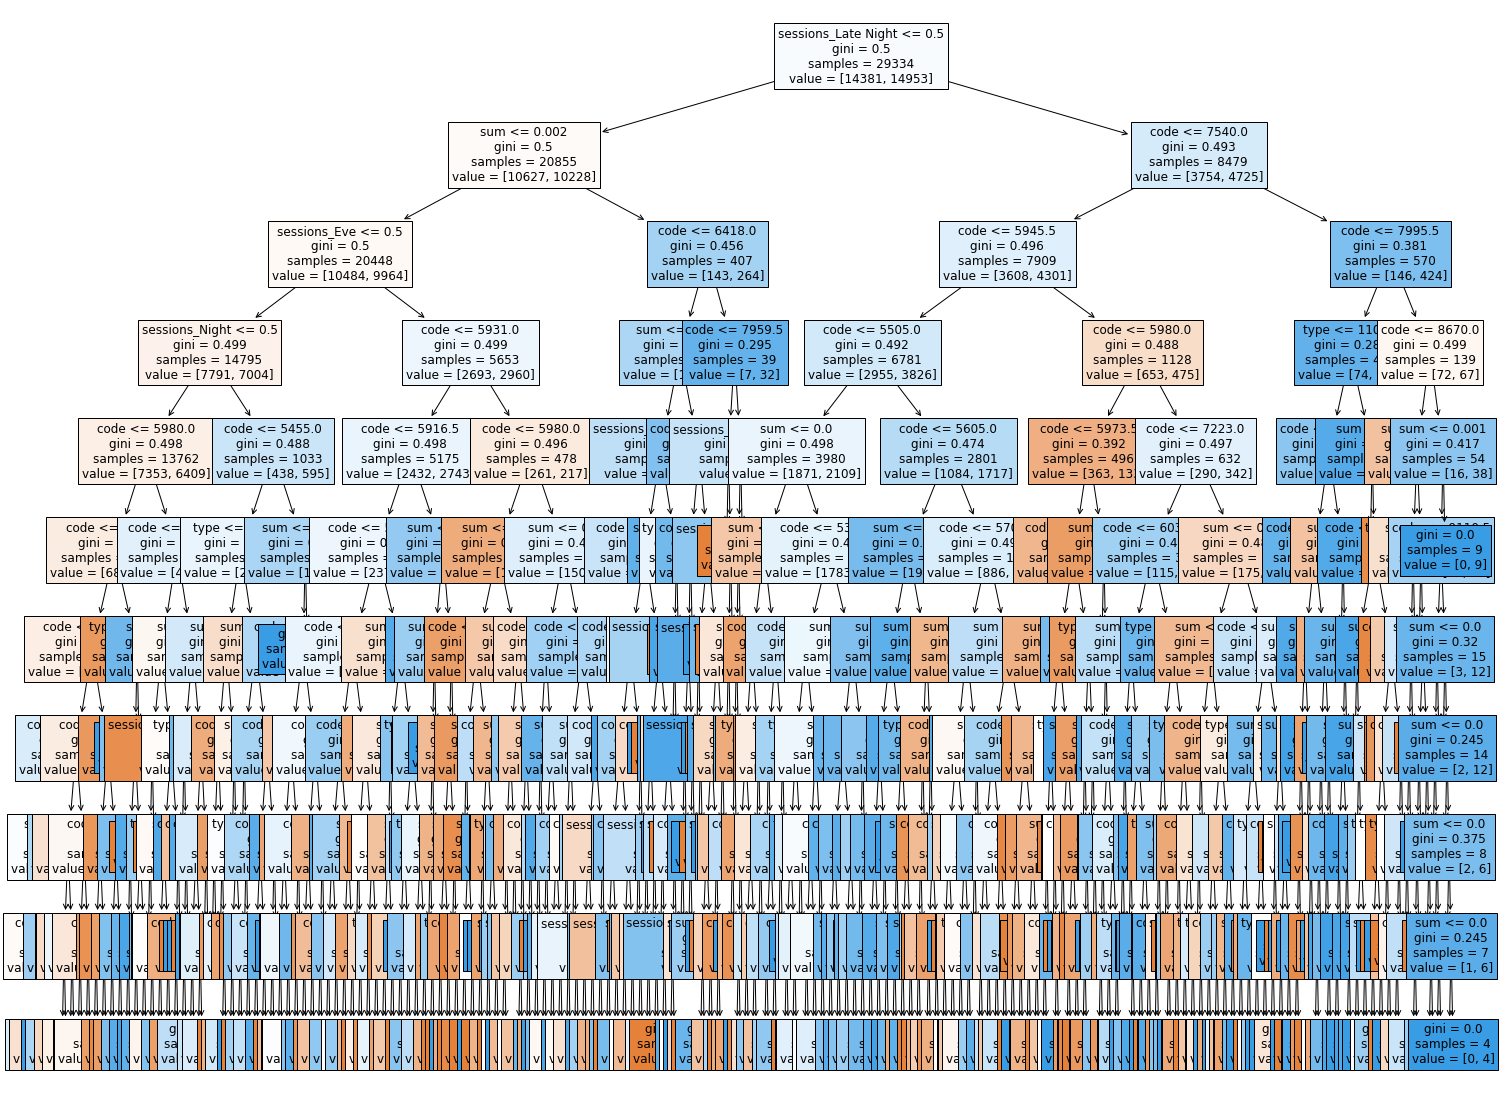

In [70]:
fig = plt.figure(figsize = (25, 20))
_= tree.plot_tree(dt,
                 feature_names = feature_names,
                 filled = True,
                 fontsize = 12)

### Random Forest

In [71]:
parameters = {'max_depth':range(3, 20)}
rf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs = 4)
rf.fit(X = X, y = y)
rf_model = rf.best_estimator_
print (rf.best_score_, rf.best_params_)

0.5488718828107311 {'max_depth': 12}


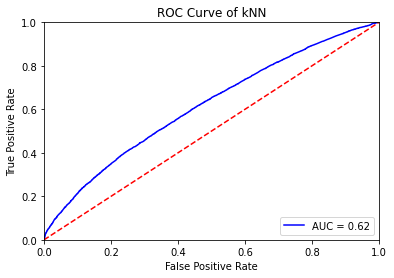

In [72]:
rf = RandomForestClassifier(max_depth = 13, random_state = 0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_scores = rf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [73]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62      9415
           1       0.58      0.50      0.54      8942

    accuracy                           0.58     18357
   macro avg       0.58      0.58      0.58     18357
weighted avg       0.58      0.58      0.58     18357



In [74]:
conf_matrix = confusion_matrix(y_test, y_pred).T #.transpose()
conf_matrix

array([[6232, 4484],
       [3183, 4458]], dtype=int64)

#### For sales dataframe 

In [75]:
parameters = {'max_depth':range(3, 20)}
rf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs = 4)
rf.fit(X = X1, y = y1)
rf_model = rf.best_estimator_
print (rf.best_score_, rf.best_params_)

0.5748063665486542 {'max_depth': 11}


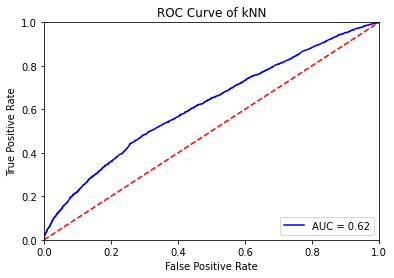

In [76]:
rf = RandomForestClassifier(max_depth = 10, random_state = 0)
rf.fit(X1_train, y1_train)

y_pred = rf.predict(X1_test)
y_scores = rf.predict_proba(X1_test)
fpr, tpr, threshold = roc_curve(y1_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [77]:
print(classification_report(y1_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57      3694
           1       0.57      0.61      0.59      3640

    accuracy                           0.58      7334
   macro avg       0.58      0.58      0.58      7334
weighted avg       0.58      0.58      0.58      7334



In [78]:
conf_matrix = confusion_matrix(y1_test, y_pred).T #.transpose()
conf_matrix

array([[2037, 1420],
       [1657, 2220]], dtype=int64)

# Analysis

In [79]:
def plot_roc_curve_multiple_classifiers(X_test, y_true, clf_list,
                                        clf_names, class_num=1):
    for i, clf in enumerate(clf_list):
        pred = clf.predict_proba(X_test)[:, class_num]
        fpr, tpr, thresh = metrics.roc_curve(y_true, pred)
        auc = metrics.roc_auc_score(y_true, pred)
        label_plot = clf_names[i] + ' auc=' +str(auc.round(2))
        plt.plot(fpr,tpr,label=label_plot)
        plt.legend(loc='best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

def plot_precision_recall_curve_multiple_classifiers(X_test, y_true,
                                                     clf_list,
                                                     clf_names,
                                                     class_num=1):
    for i, clf in enumerate(clf_list):
        pred = clf.predict_proba(X_test)[:, class_num]
        precision, recall, thresholds = metrics.precision_recall_curve(y_true, pred)
        auc = metrics.average_precision_score(y_true, pred)
        
        label_plot = clf_names[i] + ' auc=' +str(auc.round(2))
        plt.plot(recall,precision,label=label_plot)
        plt.legend(loc='best')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        
def plot_multiple_model_evaluation(X_test, y_true,
                                   clf_list, clf_names, class_num=1):

    plt.subplots(figsize=(15, 4))

    plt.subplot(121)
    plt.title('ROC Curve')
    plot_roc_curve_multiple_classifiers(X_test, y_test, clf_list, clf_names)

    plt.subplot(122)
    plt.title('Precision Recall Curve')
    plot_precision_recall_curve_multiple_classifiers(X_test, y_test, clf_list, clf_names)
    plt.show()

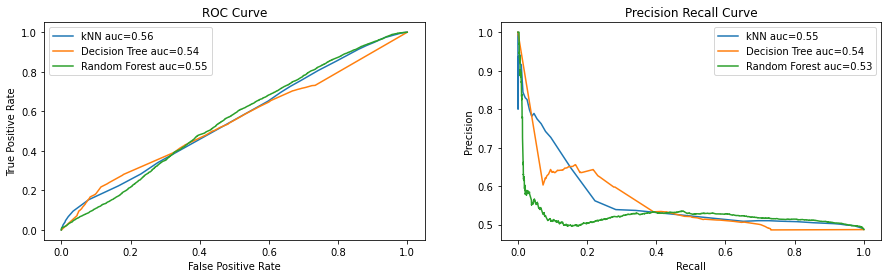

In [80]:
#sales dataset
clf_names = ['kNN', 'Decision Tree', 'Random Forest']
clf_list = [knn, dt, rf]
plot_multiple_model_evaluation(X_test, y_test, clf_list, clf_names)

Evaluating the Random Forest model, decision tree, knn on Validation data.
Analysing the result in the validation dataset with a prediction threshold of 61%

We were able to correctly classify our data, but the overall accuracy score of 0.55 to 0.59 is not very good. It looks like we need more data (more features or a larger data set) to build a more reliable model.

Also from the ROC curve plot we got AUC = 0.61-0.62 which tells us Acceptable discrimination

Comparing Random forest and Decision tree, Random fores has a higher precision (0.58 vs. 0.57) 
and higher AUC (0.55 vs. 0.54). Their Sensitivity also differs by 0.01. Which says that Random forest is more suitable for our data

Random forest is the best algorithm for our dataset

We can see from the data visualization analysis that the transaction code "financial institution - manual withdrawal" appears the most in the transaction data. The highest number of transaction code descriptions were "Calls Using a Recorded Phone," "Grocery Stores, Supermarkets," and "Financial Institutions - Manual Withdrawals," all of which had similar numbers.

If we talk about the types of transactions, then most often we met "Purchase. Foreign POS." .

By evaluating the correlation between the values in our database, we can conclude that the values among themselves have a low correlation, which indicates a weak relationship. At the same time, the largest correlation coefficient was found between the type and transaction code.

If we talk about the amount of the transaction, then it has too much difference, since it includes both negative and positive values(depending on the operation), therefore they have a huge number of deviations

# Conclusion

In short, we tried to predict the sex of the client based on the available dataset, to this end we had to help KNN, Desicion tree, Random forest machine learning algorithms 

Neither KNN, Random Forest, nor the Decision tree algorithm are very useful in predicting customer gender based on time of day, code, type and sum attributes. This indicates that the data does not have the ability to predict. This is not a big surprise, indicating that there is no significant difference between genders when it comes to these variables.

Possible solutions could be to extract new variables from the dataset (e.g. try to divide transactions by the time of year in which they occurred based on days), Optimize our current model - Find new hyperparameters that improve the roc AUC metric;
